# Description:

    Investigate OTU abundances



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [2]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [6]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 780K
lrwxrwxrwx 1 bryan bryan  130 Nov 10 19:10 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan  143 Nov 10 19:10 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 3.6K Oct  1 10:35 Paeni_relabund.pdf
-rw-rw-r-- 1 bryan bryan 3.6K Oct  1 10:35 Paenibacillus_relabund.pdf
-rw-rw-r-- 1 bryan bryan 3.6K Oct  1 10:29 firmicutes_relabund.pdf
-rw-rw-r-- 1 bryan bryan 422K Oct  1 09:50 sample_rel-abundance.pdf
-rw-rw-r-- 1 bryan bryan 325K Sep 30 10:00 sample_abundance.pdf
-rw-rw-r-- 1 bryan bryan 5.2K Sep 30 06:35 RankAbundance.pdf


# Loading/editting OTU table

In [7]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [8]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

## Filter and transform samples
Transform to relative abundance and
remove taxa not seen more than 3 times in at least 5% of the samples 

In [9]:
%%R 
sparcity.thresh = 0.05

# filtering/normalizing
#physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq, function(x) sum(x > 3) > (sparcity.thresh * length(x)), TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3635 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 3635 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3635 tips and 3634 internal nodes ]


In [11]:
%%R 
sparcity.thresh = 0.01

# filtering/normalizing
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > .001) > (sparcity.thresh * length(x)), TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 879 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 879 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 879 tips and 878 internal nodes ]


# Taxa distribution

## Rank Abundance

In [11]:
%%R
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3635 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 3635 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3635 tips and 3634 internal nodes ]


In [28]:
%%R
getwd()

[1] "/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration"


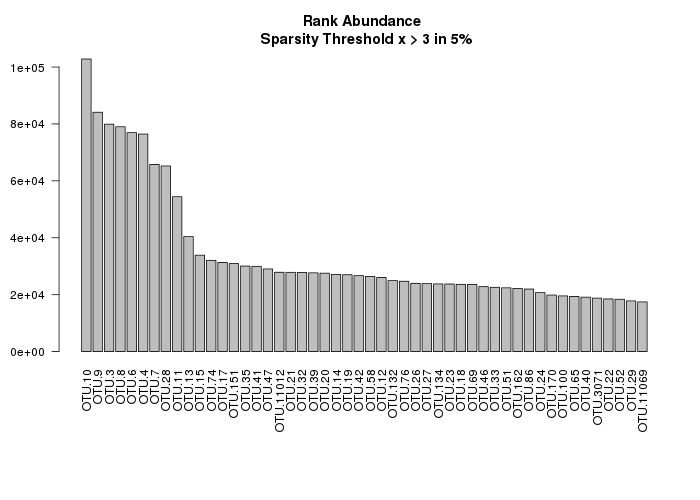

In [27]:
%%R -w 700 -h 500
par(mar = c(10, 4, 4, 2) + 0.1) # make more room on bottom margin
N <- 50

#print to file
pdf(file = "RankAbundance")
barplot(sort(taxa_sums(physeq.R), TRUE)[1:N], las=2, 
        main = "Rank Abundance \n Sparsity Threshold x > 3 in 5%")
dev.off()

#print to screen
barplot(sort(taxa_sums(physeq.R), TRUE)[1:N], las=2, 
        main = "Rank Abundance \n Sparsity Threshold x > 3 in 5%")

## Generate abundance bar plots for each sample

In [40]:
%%R
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [12]:
%%R
s.df = sample_data(physeq.thresh)
s.df.o =  s.df[with(s.df, order(Plant, Treatment))]
head(s.df.o) %>% print
samples = sample_names(s.df.o)

                           X.sample Library Primer_Plate Primer_Well_ID
sample5-1.22_Nneg sample5-1.22_Nneg       1            1             A4
sample5-2.29_Nneg sample5-2.29_Nneg       1            1             C4
sample5-4.28_Nneg sample5-4.28_Nneg       1            1             G4
sample5-3.27_Nneg sample5-3.27_Nneg       1            1             E4
sample5-4.28_Npos sample5-4.28_Npos       1            1             H4
sample5-1.22_Npos sample5-1.22_Npos       1            1             B4
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample5-1.22_Nneg                  25                25         25 1.22_Nneg
sample5-2.29_Nneg                  27                27         27 2.29_Nneg
sample5-4.28_Nneg                  31                31         31 4.28_Nneg
sample5-3.27_Nneg                  29                29         29 3.27_Nneg
sample5-4.28_Npos                  32                32         32 4.28_Npos
sample5-1.22_Npos                 

In [14]:
%%R -w 600 -h 400

pdf("sample_abundance.pdf", onefile = TRUE)

N = nsamples(physeq.R)

s.df = sample_data(physeq.R)
s.df.o =  s.df[with(s.df, order(Plant, Treatment))]
samples = sample_names(s.df.o)


for(i in 1:N){
    samplename = samples[i]
    sample = subset_samples(physeq.R, X.sample == samplename)
  

    TopOTUs = names(sort(taxa_sums(sample), TRUE)[1:50])
    Top = prune_taxa(TopOTUs, sample)
    title = paste(sample_data(Top)$Plant, samplename, sample_sums(Top), sep = " ")
    p1 = barplot(sort(taxa_sums(Top), TRUE), las=2, 
        main = title)
    plots[[i]] = p1  # add each plot into plot list
}




dev.off()


Error in plots[[i]] = p1 : object 'plots' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in plots[[i]] = p1 : object 'plots' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Explore OTU relative abundance

In [18]:
%%R -i workDir

pdf("sample_rel-abundance.pdf", onefile = TRUE)

N = nsamples(physeq.snorm)

s.df = sample_data(physeq.snorm)
s.df.o =  s.df[with(s.df, order(Plant, Treatment))]
samples = sample_names(s.df.o)

for(i in 1:N){
    samplename = samples[i]
    sample = subset_samples(physeq.snorm, X.sample == samplename)
  

    TopOTUs = names(sort(taxa_sums(sample), TRUE)[1:50])
    Top = prune_taxa(TopOTUs, sample)
    title = paste(sample_data(Top)$Plant, samplename, sample_sums(Top), sep = " ")
    plot =  barplot(sort(taxa_sums(Top), TRUE), las=2, 
        main = title)
    plot
}

dev.off()



png 
  2 


## Explore firmicutes

In [89]:
%%R
colnames(tax_table(phy)) = c("Kingdom", "Phylum",  "Class",   "Order",   
                         "Family",  "Genus",   "Species", "Strain")

In [91]:
%%R
get_taxa_unique(phy, "Phylum")

 [1] "Acidobacteria"           "Proteobacteria"         
 [3] "Candidate_division_WS3"  "Nitrospirae"            
 [5] "Spirochaetes"            "Verrucomicrobia"        
 [7] "Chloroflexi"             "Candidate_division_BRC1"
 [9] "Planctomycetes"          NA                       
[11] "Chlorobi"                "Bacteroidetes"          
[13] "Elusimicrobia"           "JL-ETNP-Z39"            
[15] "Gemmatimonadetes"        "Fibrobacteres"          
[17] "Firmicutes"              "Deinococcus-Thermus"    
[19] "Cyanobacteria"           "Armatimonadetes"        
[21] "Thermotogae"             "Actinobacteria"         
[23] "Candidate_division_OD1"  "TM6"                    


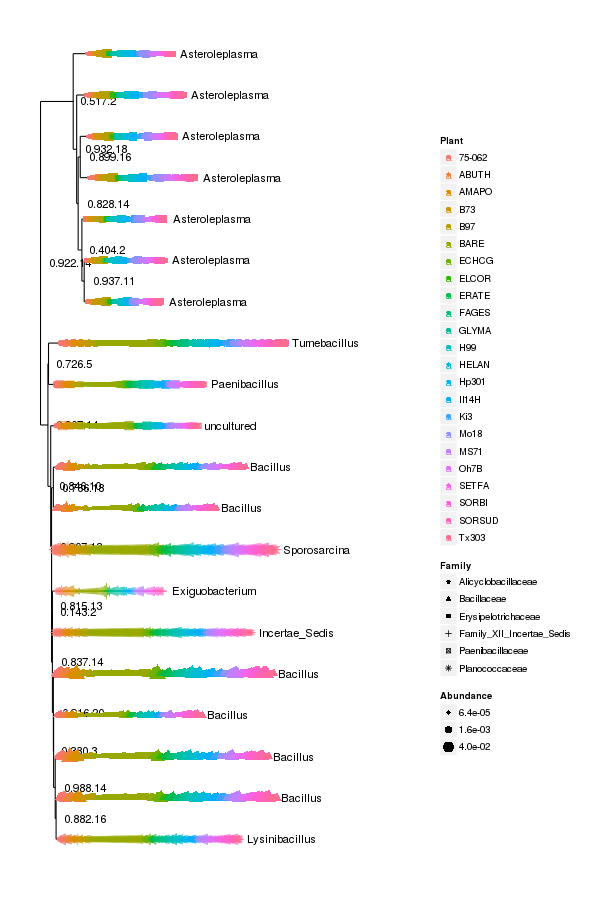

In [92]:
%%R -w 600 -h 900
Rhiz.f = subset_taxa(phy, Phylum == "Firmicutes")
topNOTUs = names(sort(taxa_sums(Rhiz.f), TRUE)[1:20])
Rhiz.ft = prune_taxa(topNOTUs, Rhiz.f)
plot_tree(Rhiz.ft, color = "Plant", shape = "Family", label.tips = "Genus", 
          size = "abundance", plot.margin = 0.5, ladderize = TRUE)

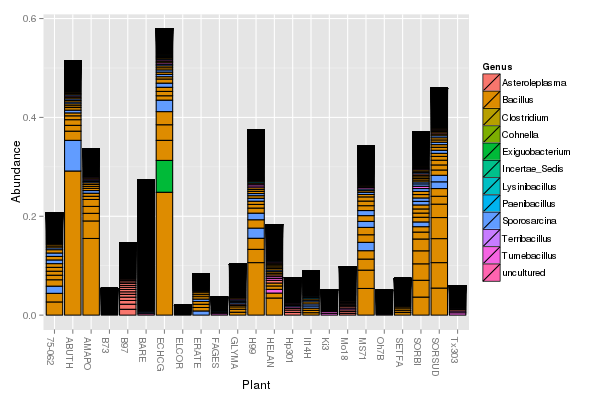

In [130]:
%%R -w 600 -h 400
p1 = plot_bar(Rhiz.f, x="Plant", fill="Genus")

#pdf("firmicutes_relabund.pdf")
p1
#dev.off()

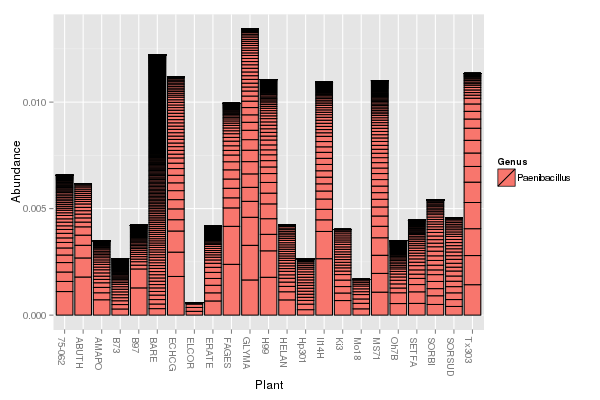

In [128]:
%%R -w 600 -h 400 -i workDir
setwd(workDir)
Rhiz.p = subset_taxa(phy, Genus == "Paenibacillus")

#pdf("Paeni_relabund.pdf")
plot_bar(Rhiz.p, x="Plant", fill="Genus")
#dev.off()
